<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/diffusion%20test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [103]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train/255

In [245]:
class ResNetBlock(layers.Layer):
    def __init__(self, num_filters):
        super(ResNetBlock, self).__init__()
        self.inputConv = layers.Conv2D(num_filters, 1, padding='same')
        self.conv1 = layers.Conv2D(num_filters, (3, 3), padding='same',activation='LeakyReLU')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(num_filters, (3, 3), padding='same',activation='LeakyReLU')
        self.bn2 = layers.BatchNormalization()

    def call(self, inputs):
        inpx = self.inputConv(inputs)
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        return layers.add([x, inpx])

In [270]:
def model():

    input_noise = layers.Input(shape=(28,28,1))
    input_digit = layers.Input(shape=())
    digit = layers.Embedding(1000, 100)(input_digit)
    digit = layers.Dense(28*28*7)(digit)
    digit = layers.Reshape((28,28,7))(digit)

    x = layers.concatenate([input_noise, digit])

    x = ResNetBlock(64)(x)

    x = layers.MaxPool2D(2)(x)

    x = ResNetBlock(64)(x)

    x = layers.MaxPool2D(2)(x)


    x = ResNetBlock(64)(x)
    x = layers.UpSampling2D(2)(x)

    x = ResNetBlock(64)(x)
    x = layers.UpSampling2D(2)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(1,3,1,padding='same',activation=None)(x)

    model = tf.keras.models.Model(inputs=([input_noise,input_digit]), outputs=x)
    model.summary()
    return model

In [271]:
generator = model()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_52 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 embedding_24 (Embedding)    (None, 100)                  100000    ['input_52[0][0]']            
                                                                                                  
 dense_23 (Dense)            (None, 5488)                 554288    ['embedding_24[0][0]']        
                                                                                                  
 input_51 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                           

In [272]:
x_test = tf.expand_dims(x_train,axis = -1)

print(x_test.shape)

(60000, 28, 28, 1)


In [273]:
noise = tf.random.normal(shape=(10,28,28,1),mean=.5,stddev=1)
print(np.max(noise))

4.1646557


In [274]:
def interpolate(array1,array2,factor):
  interpolated_array = tf.math.add(
    tf.multiply(array1, 1.0 - factor),
    tf.multiply(array2, factor))
  return interpolated_array

In [275]:
def noised(input,t_steps):
  step = np.random.randint(0,t_steps)
  noise = tf.random.normal(shape=input.shape,mean=.5,stddev=1)
  input_tensor = tf.cast(input,tf.float32)
  output = interpolate(noise,input_tensor,step/t_steps)
  return output, noise, step

52


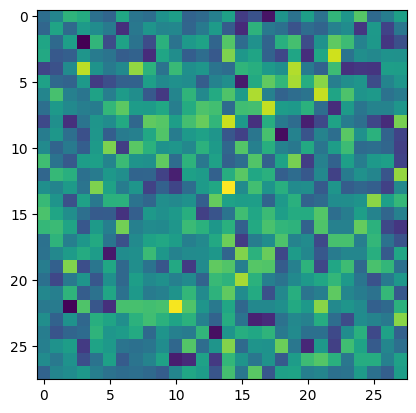

In [276]:
output, noise, step = noised(x_test[0:10],100)

print(step)
plt.imshow(output[0])

In [277]:
model = generator  # Your diffusion model
loss_fn = tf.keras.losses.MeanSquaredError()  # Your loss function
optimizer = tf.keras.optimizers.Adam()
BATCH_SIZE = 64
# Define the training loop
@tf.function
def train_step(images):
    with tf.GradientTape() as tape:
        # Add noise to the images
        noisy_images,target,step = noised(images, 1000)
        step = np.full((BATCH_SIZE),step)
        # Run the diffusion model
        predictions = generator([noisy_images,step])

        # Compute the loss
        loss = loss_fn(target, predictions)

    # Compute gradients and update the model
    gradients = tape.gradient(loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(gradients, generator.trainable_variables))
    tf.print(loss)
    return loss


def train(dataset, epochs):
  for epoch in range(epochs):
    for batch in range(len(dataset) // BATCH_SIZE):

            images = dataset[batch * BATCH_SIZE: (batch+1) * BATCH_SIZE]

            train_step(images)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      print(epoch)

In [ ]:

EPOCHS = 1000
train(x_test, EPOCHS)

1.29500592
3.61121035
1.08202505
1.12012064
1.21586263
1.13799751
1.04046869
1.03432155
1.10267293
1.06562507
1.02195418
1.01498759
1.03638101
1.04911351
1.02452981
1.02761102
1.02065325
1.00087726
1.01110387
1.00415325
1.00560439
0.992575645
0.990335286
0.989605486
0.983756423
0.986993432
0.994091094
0.98932749
0.986707509
0.983487785
1.00067592
0.991183043
0.99424547
0.990627348
0.981870592
0.970627427
0.981906176
0.97758615
0.9838956
0.978208423
0.980966449
0.967532277
0.967967272
0.975720465
0.979012489
0.962536097
0.974484
0.973563433
0.95942688
0.967540681
0.971476555
0.967275321
0.954881489
0.961868346
0.979141414
0.960194707
0.957238197
0.962778389
0.954764843
0.957216442
0.946906447
0.96452564
0.946800172
0.951190174
0.953530669
0.939611077
0.948455
0.942426264
0.944727123
0.945210814
0.944117188
0.945650816
0.94253397
0.937809467
0.941954732
0.922306478
0.926706254
0.919122398
0.930422127
0.933607757
0.921994209
0.921580791
0.91868639
0.916955769
0.913890123
0.916065037
0.901

In [266]:
current_input = tf.random.normal((1,28,28,1),mean=.5,stddev=1)
for i in range(1000):

  step = np.full(1,i)
  step = tf.cast(step,dtype=tf.float32)
  noise = generator([current_input,step])
  current_input = current_input-(noise/1000)
  #current_input = np.expand_dims(current_input,axis=0)

In [228]:
noise = tf.random.normal((1,28,28,1),mean=.5,stddev=1)
digit = np.full(1,1)
digit = tf.cast(digit,dtype=tf.float32)
img = model([noise,digit])


TypeError: ignored

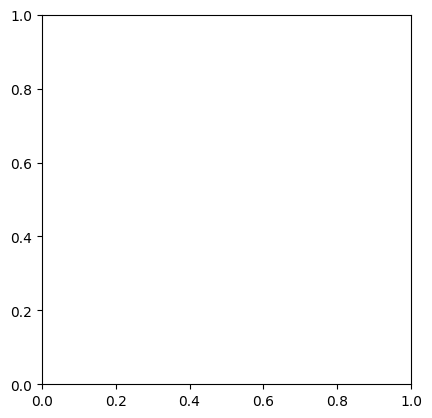

In [269]:
plt.imshow(np.min(noise[0]))